# Intrinsic logdust dataset

In [ ]:
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import sklearn
%matplotlib inline

In [19]:
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [3]:
# import GP regressor and associated kernels
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [4]:
# initialize random number seed, so that results are replicable
random_seed = 7876  # this is "SURP" on the number pad (can be changed)
np.random.seed(random_seed)

In [5]:
# define our Gaussian Process
sigma, scale = 1., 1. 
kernel = ConstantKernel(constant_value=sigma**2) * RBF(length_scale=scale)
gp = GaussianProcessRegressor(kernel=kernel)

In [6]:
ngrid, edge = 21, 2.5
xgrid, ygrid, zgrid = [np.linspace(-edge, edge, ngrid) for i in range(3)]
Xgrid = np.array([[x, y, z] for x in xgrid for y in ygrid for z in zgrid])
print(np.shape(Xgrid))

(9261, 3)


In [7]:
Ygrid_mean, Ygrid_cov = gp.predict(Xgrid, return_cov=True)
print(np.shape(Ygrid_mean), np.shape(Ygrid_cov))

(9261,) (9261, 9261)


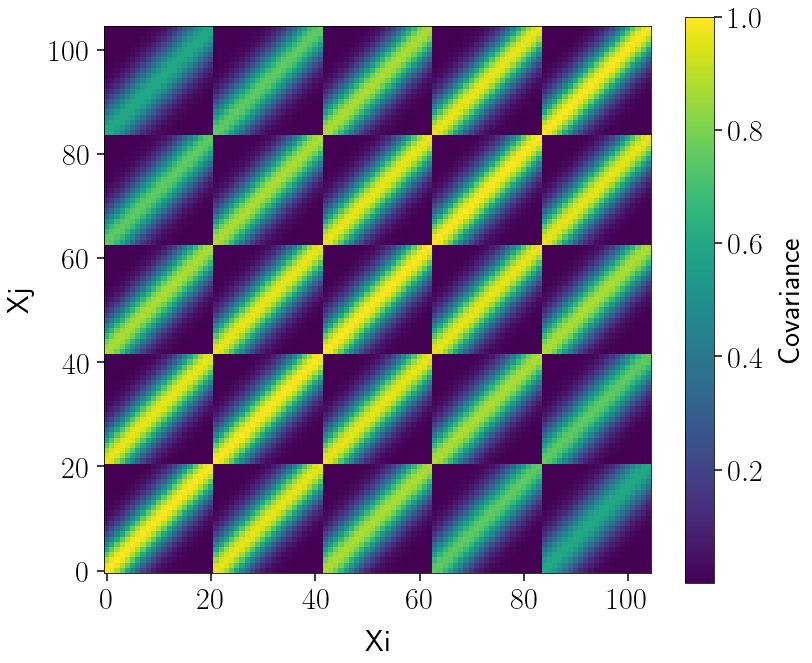

In [8]:
# this is a 100 x 100 grid of the covariance matrix of each (x,y,z) with each other
# the banded structure is because every ngrid points, we have looped through one of x, y, or z
# the different shading is because closer points have higher covariance
plt.figure(figsize=(12, 10))
plt.imshow(Ygrid_cov[:ngrid*5,:ngrid*5], origin='lower')
plt.colorbar(label='Covariance')
plt.xlabel('Xi')
plt.ylabel('Xj')
plt.tight_layout()

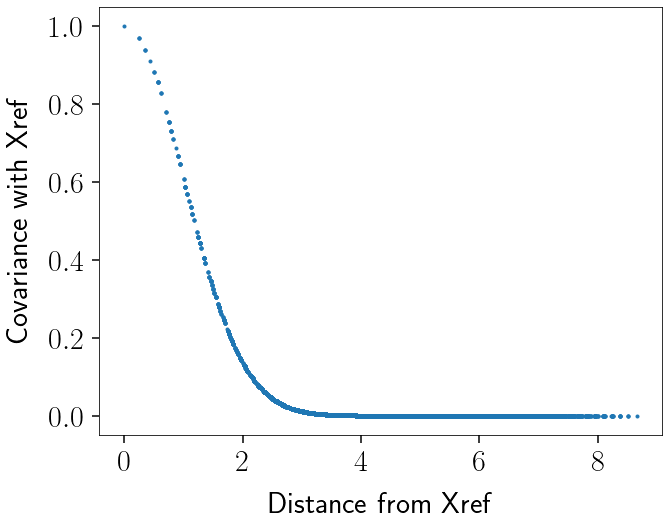

In [9]:
# convert all positions to be relative to some reference point
idx = 0  # define index
Xref = Xgrid[idx]  # get reference point
Rref = np.sqrt(np.sum((Xgrid - Xref)**2, axis=1))  # define distance to reference point

plt.figure(figsize=(10, 8))
plt.plot(Rref, Ygrid_cov[:, idx], '.')
plt.xlabel('Distance from Xref')
plt.ylabel('Covariance with Xref')
plt.tight_layout()

In [10]:
Ygrid_samps = gp.sample_y(Xgrid).reshape(len(Xgrid))

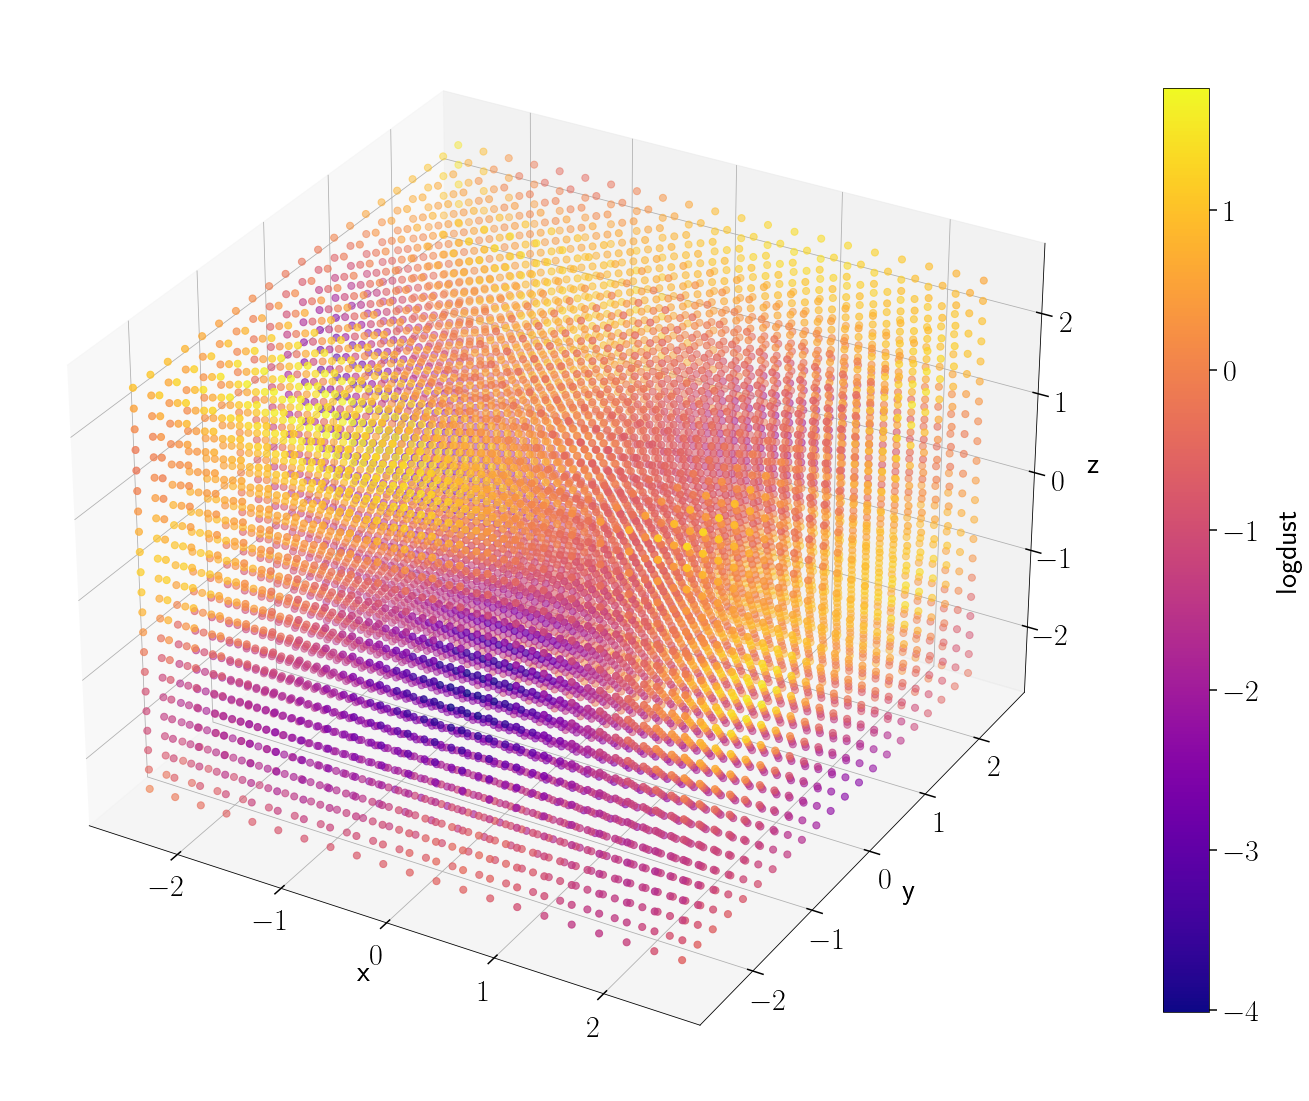

In [23]:
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(Xgrid[:, 0], Xgrid[:, 1], Xgrid[:, 2], c=logdust_grid, cmap='plasma', s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.85)
cbar.set_label('logdust')
plt.tight_layout()
plt.savefig('plots/logdust.png', bbox_inches='tight')

In [12]:
from scipy import interpolate
logdust = interpolate.Rbf(Xgrid[:, 0], Xgrid[:, 1], Xgrid[:, 2], Ygrid_samps, 
                          function='thin_plate',  # specific interpolation method
                          smooth=0)  # smoothing parameter (0=exact fit)

In [13]:
# simulate stars
n_stars = 10000  # with more stars, our model should get better

X = np.random.uniform(-edge, edge, size=(n_stars, 3))  # true positions

# evaluate positions over our log-dust density field
Y = logdust(X[:, 0], X[:, 1], X[:, 2])  # intrinsic values

# training/validation/testing splits
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

# split data
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]

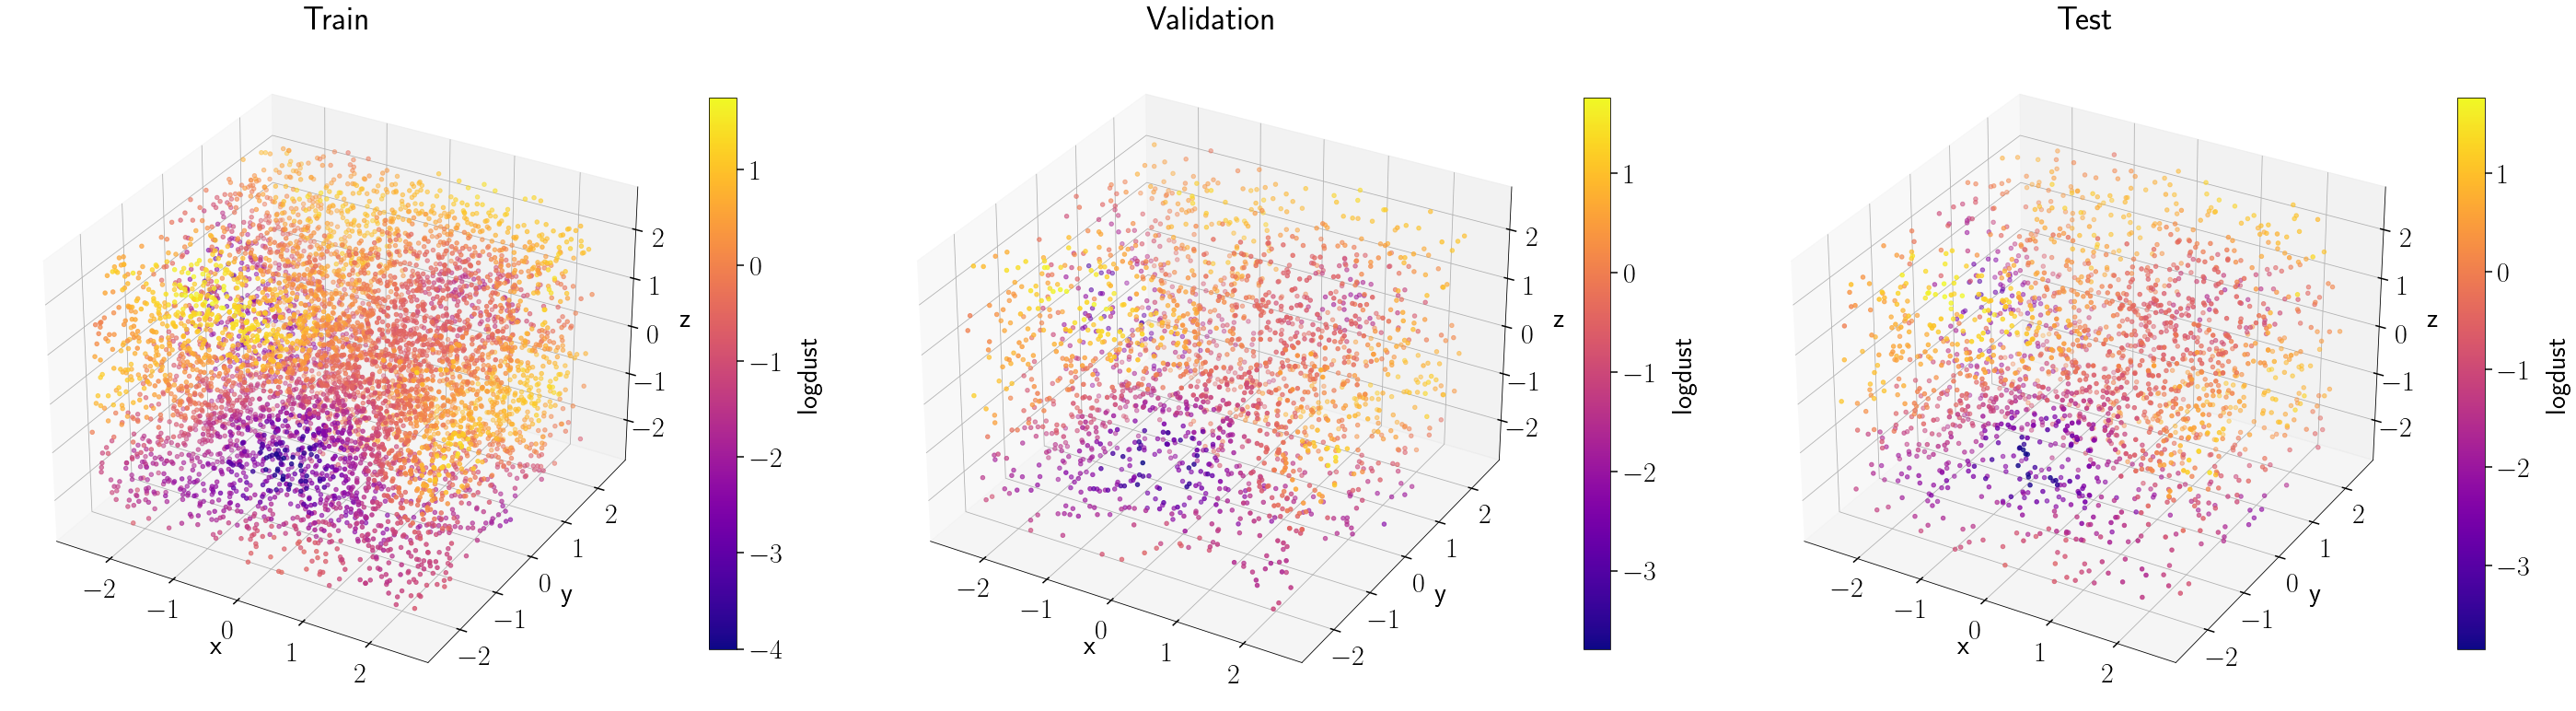

In [14]:
fig = plt.figure(figsize=(40, 12))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=Y_train, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('logdust')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], c=Y_valid, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('logdust')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=Y_test, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('logdust')
ax.set_title('Test')

plt.tight_layout()

In [15]:
import pickle
with open('logdust_3d_func.pkl', 'wb') as f:
    pickle.dump(logdust, f)
np.savez('logdust_3d_samps', 
     Xgrid=Xgrid, logdust_grid=Ygrid_samps,  # model grid
     X_train=X_train, X_valid=X_valid, X_test=X_test,  # locations (true)
     Y_train=Y_train, Y_valid=Y_valid, Y_test=Y_test)  # dust (true)

# Dust attenuation dataset

In [1]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
logdust_func = open("logdust_3d_func.pkl", "rb")
logdust = pickle.load(logdust_func)

In [9]:
def cart2pol(x, y, z):
    '''Return polar coordinate from cartesian coordinate'''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    if (x > 0):
        phi = np.arctan(y/x)
    elif (x < 0):
        phi = np.arctan(y/x) +np.pi 
    else:
        phi = np.pi / 2
    return [r, theta, phi] 

def pol2cart(r, theta, phi):
    '''Return cartesian coordinate from polar coordinate'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]

In [3]:
# get train/valid/test and Xgrid positions from last dataset
data = np.load('datasets/logdust_3d_samps.npz')
xgrid, ygrid = np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)
Xgrid, logdust_grid = data['Xgrid'], data['logdust_grid']
X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']

In [ ]:
# evaluate full dust grid
n_stars = 10000  # with more stars, our model should get better
ngrid, edge = 21, 2.5
delta_r = 1e-2  # for reiman sum over

Ygrid_samps = []
count = 0

for x, y, z in Xgrid: # using intrinsic polar positions 
    dust = [] # list of intrinsic dust at points delta_r apart along integration line
    # get points delta_r apart from (0,0) to pt
    r, theta, phi = cart2pol(x, y, z)
    for r_prime in np.arange(0, r, delta_r):
        x_prime, y_prime, z_prime = pol2cart(r_prime, theta, phi)
        dust.append(np.exp(logdust(x_prime, y_prime, z_prime))) # exponentiating to get rho
    # multiply by delta_r
    dust *= np.array([delta_r])
    Ygrid_samps.append(np.sum(dust))
    print(count)
    count += 1
Ygrid_samps = np.asarray(Ygrid_samps)

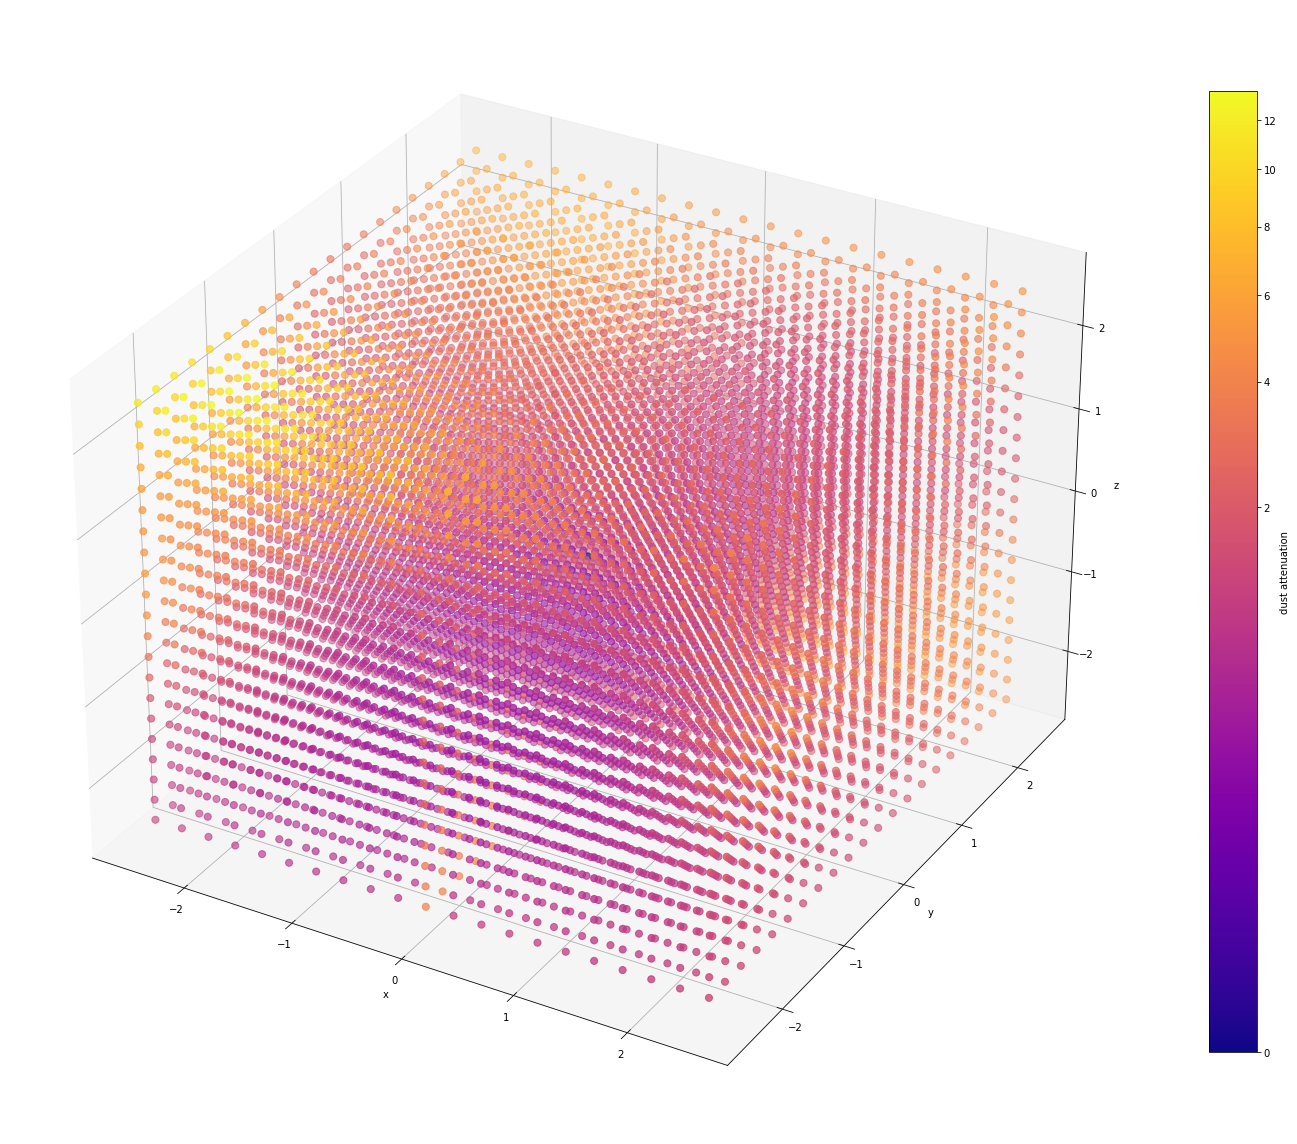

In [5]:
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(Xgrid[:, 0], Xgrid[:, 1], Xgrid[:, 2], c=Ygrid_samps, cmap='plasma', norm=matplotlib.colors.PowerNorm(gamma=0.3), s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.85)
cbar.set_label('dust attenuation')
plt.tight_layout()
plt.savefig('plots/Integrated-dust.png', bbox_inches='tight')

In [3]:
n_stars = 10000  # with more stars, our model should get better
ngrid, edge = 21, 2.5
delta_r = 1e-2  # for reiman sum over

In [ ]:
# evaluate train/valid/test dust
X = X_train.tolist() + X_valid.tolist() + X_test.tolist() # get from prev dataset
Y = []
print(len(X))
count = 0

for x, y, z in X: # using intrinsic polar positions 
    dust = [] # list of intrinsic dust at points delta_r apart along integration line
    # get points delta_r apart from (0,0) to pt
    r, theta, phi = cart2pol(x, y, z)
    for r_prime in np.arange(0, r, delta_r):
        x_prime, y_prime, z_prime = pol2cart(r_prime, theta, phi)
        dust.append(np.exp(logdust(x_prime, y_prime, z_prime))) # exponentiating to get rho
    # multiply by delta_r
    dust *= np.array([delta_r])
    Y.append(np.sum(dust))
    print(count)
    count += 1
Y = np.asarray(Y)

# training/validation/testing splits
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

# split data
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]

In [ ]:
fig = plt.figure(figsize=(40, 12))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=np.arcsinh(Y_train), cmap='plasma', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], c=np.arcsinh(Y_valid), cmap='plasma', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=np.arcsinh(Y_test), cmap='plasma', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation')
ax.set_title('Test')
plt.savefig('plots/test-valid-train-dust.png', bbox_inches='tight')
plt.tight_layout()

In [11]:
np.savez('datasets/dustattenuation_3d_samps', 
     Xgrid=Xgrid, dustattenuation_grid=Ygrid_samps,  # model grid
     X_train=X_train, X_valid=X_valid, X_test=X_test,  # locations (true)
     Y_train=Y_train, Y_valid=Y_valid, Y_test=Y_test)  # dust (true)

# Dust attenuation with errors dataset 

In [1]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
logdust_func = open("logdust_3d_func.pkl", "rb")
logdust = pickle.load(logdust_func)

In [5]:
# training/validation/testing splits
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

# get train/valid/test and Xgrid positions from last dataset
data = np.load('datasets/dustattenuation_3d_samps.npz')
Xgrid, Y_grid = data['Xgrid'], data['dustattenuation_grid']
X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']
Y_train, Y_valid, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']

In [6]:
samples = 10
stdlogr = np.log(1.1) # std dev for X samples - 10% error
stdA = 0.1
delta_r = 0.2

In [7]:
# LATER get Xgrid, Ygrid_samps samples
Xogrid, Yo_grid = [], []

In [10]:
# get train/test/validation samples
X = X_train.tolist() + X_valid.tolist() + X_test.tolist() # get from prev dataset
X_obs, Y_obs = [], []
dust = list()

for i,xyz in enumerate(X):
    x, y, z = xyz[0], xyz[1], xyz[2]
    X_obs.append([]) # add empty list for 100 samples
    Y_obs.append([])
    dust = list()
    for s in range(samples): # take 100 samples
        # X samples 
        r, theta, phi = cart2pol(x, y, z)
        logrerr = np.random.normal(np.log(r), stdlogr) #10% error
        rerr = np.exp(logrerr) # r samp
        xs, ys, zs = pol2cart(rerr, theta, phi)
        X_obs[i].append([xs, ys, zs])
        # Y samples
        for r_prime in np.arange(0, r, delta_r):
            x_prime, y_prime, z_prime = pol2cart(r_prime, theta, phi)
            dust = list(dust)
            dust.append(np.exp(logdust(x_prime, y_prime, z_prime))) # exponentiating to get rho
        dust *= np.array([delta_r])
        trueA = np.sum(dust)
        errA = np.random.normal(trueA, stdA) 
        Y_obs[i].append(errA)
    print(i)
        
X_obs = np.asarray(X_obs)
Y_obs = np.asarray(Y_obs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

Xo_train, Xo_valid, Xo_test = X_obs[:idx_train], X_obs[idx_train:idx_valid], X_obs[idx_valid:]
Yo_train, Yo_valid, Yo_test = Y_obs[:idx_train], Y_obs[idx_train:idx_valid], Y_obs[idx_valid:]

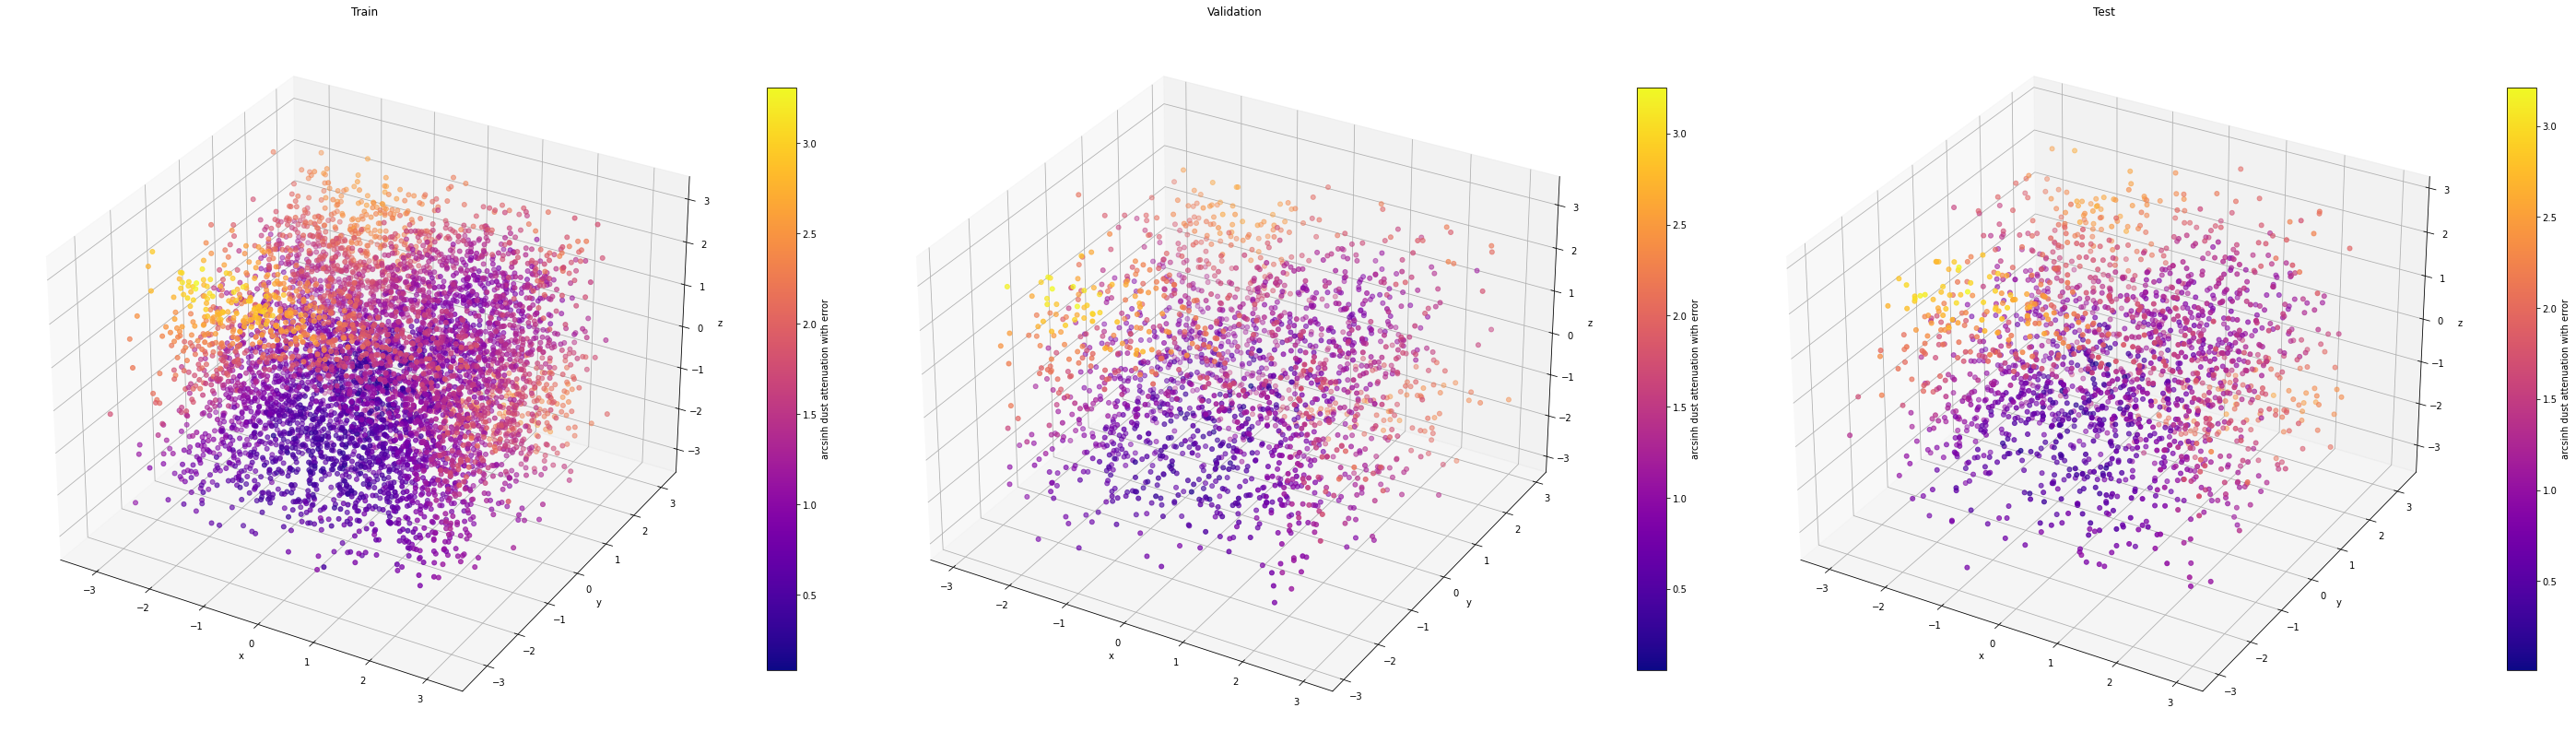

In [12]:
fig = plt.figure(figsize=(40, 12))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(Xo_train[:, 0][:, 0], Xo_train[:, 0][:, 1], Xo_train[:, 0][:, 2], c=np.arcsinh(Yo_train[:, 0]), cmap='plasma', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation with error')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(Xo_valid[:, 0][:, 0], Xo_valid[:, 0][:, 1], Xo_valid[:, 0][:, 2], c=np.arcsinh(Yo_valid[:, 0]), cmap='plasma', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation with error')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(Xo_test[:, 0][:, 0], Xo_test[:, 0][:, 1], Xo_test[:, 0][:, 2], c=np.arcsinh(Yo_test[:, 0]), cmap='plasma', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation with error')
ax.set_title('Test')
plt.savefig('plots/error_test-valid-train-dust.png', bbox_inches='tight')
plt.tight_layout()

In [12]:
np.savez('datasets/dustattenuation_3d_err_10samp', 
     Xgrid=Xgrid, dustattenuation_grid=Y_grid,  # model grid
     X_train=X_train, X_valid=X_valid, X_test=X_test,
     Xo_train=Xo_train, Xo_valid=Xo_valid, Xo_test=Xo_test,  # locations (true)
     Y_train=Y_train, Y_valid=Y_valid, Y_test=Y_test, # dust attenuation(true)
     Yo_train=Yo_train, Yo_valid=Yo_valid, Yo_test=Yo_test,
)  

In [13]:
print(np.shape(Y_obs), np.shape(X_obs))

(10000, 10) (10000, 10, 3)


# Dataset for Three js

In [1]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
logdust_func = open("logdust_3d_func.pkl", "rb")
logdust = pickle.load(logdust_func)

In [3]:
ngrid, edge = 50, 2.5
xgrid, ygrid, zgrid = [np.linspace(-edge, edge, ngrid) for i in range(3)]
Xgrid = np.array([[x, y, z] for x in xgrid for y in ygrid for z in zgrid])
print(np.shape(Xgrid))

(125000, 3)


In [4]:
import csv
import math
mindust = math.inf
maxdust = -math.inf
n_stars = 100000
from operator import itemgetter
first_item = itemgetter(0)

with open("dust.js", "w") as e:

    Xgrid = np.random.uniform(-edge, edge, size=(n_stars, 3)) #Math.random() * n - n2
    Xgrid = sorted(Xgrid, key = first_item)
    dust_vals = [np.around(logdust(x, y, z), 2) for x,y,z in Xgrid]
    # dust_vals = [x for _,x in sorted(zip(Xgrid,dust_vals))]
    e.write("let pos = [\n")
    for pos in Xgrid:
        e.write("   [" + ','.join(str(e) for e in pos) + "],\n")
    e.write("]\n\n")

    e.write("let logdust = [\n")
    for d in dust_vals:
        e.write(str(d) + ",\n")
    e.write("]\n\n")
    e.write('var data = {"pos": pos, "logdust": logdust}; ')
    # e.write('export {data};')